In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
from scripts.save_figure import save_fig

In [49]:
df = pd.read_csv("/home/bishnu/project/EDA_transaction_data/data/processed/transactions_cleaned.csv",parse_dates=['transactionDateTime', 'currentExpDate','accountOpenDate'])
transaction_df = df.copy()

### What are the most common mechants and merchantCategories by transaction count and amount?

In [50]:
# Create another column named 'merchantBrand' that stores only merchant nome (not branch id)
transaction_df['merchantBrand'] = transaction_df['merchantName'].str.split('#').str[0].str.strip()
transaction_df["merchantBrand"].value_counts()

merchantBrand
AMC                 32722
EZ Putt Putt        26158
Lyft                25133
Uber                25093
gap.com             13741
                    ...  
TMobile Wireless       87
ATT                    82
Verizon Wireless       69
Duane Reed             28
My Fitness             28
Name: count, Length: 205, dtype: int64

In [49]:
total = transaction_df.merchantBrand.value_counts().sum()
df_transactioncount_per_merchant=round((transaction_df.merchantBrand.value_counts()/total)*100,4).reset_index().head(15)
df_transactioncount_per_merchant

,merchantBrand,count
0,AMC,5.1315
1,EZ Putt Putt,4.1021
2,Lyft,3.9414
3,Uber,3.9351
4,gap.com,2.1549
5,apple.com,2.1215
6,target.com,2.1196
7,alibaba.com,2.1174
8,staples.com,2.1058
9,amazon.com,2.1016


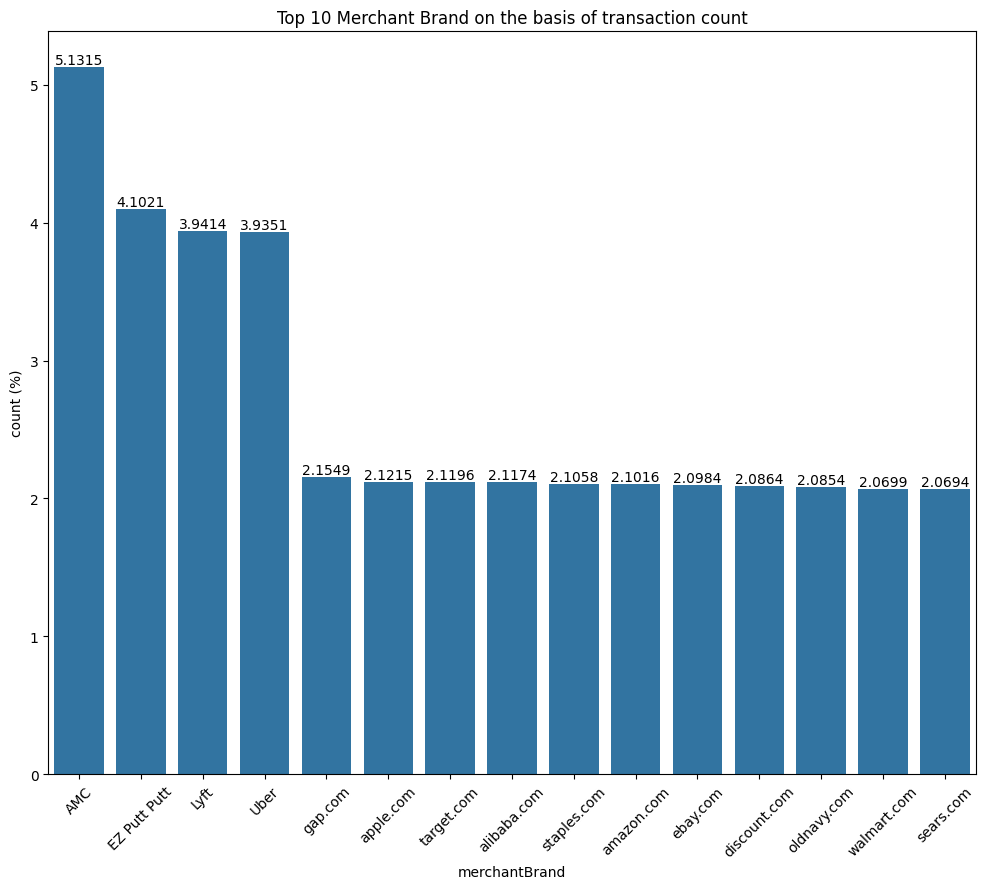

In [50]:
plt.figure(figsize=(10,9))
ax = sns.barplot(data=df_transactioncount_per_merchant,x="merchantBrand",y="count",order=df_transactioncount_per_merchant["merchantBrand"])
for i in ax.containers:
    ax.bar_label(i,)
plt.ylabel("count (%)")
plt.xlabel("merchantBrand")
plt.xticks(rotation=45)
plt.title("Top 10 Merchant Brand on the basis of transaction count")
save_fig("Top_10_Merchant_brand_(transaction_count)")
plt.show()

In [51]:
transaction_df["merchantCategoryCode"].value_counts()

merchantCategoryCode
online_retail           160474
fastfood                100572
entertainment            68655
food                     67840
rideshare                50226
online_gifts             32838
hotels                   22712
fuel                     22397
subscriptions            18258
personal care            16805
mobileapps               14500
health                   14255
online_subscriptions     11149
auto                     10073
airline                   9919
furniture                 7756
food_delivery             4936
gym                       2848
cable/phone               1453
Name: count, dtype: int64

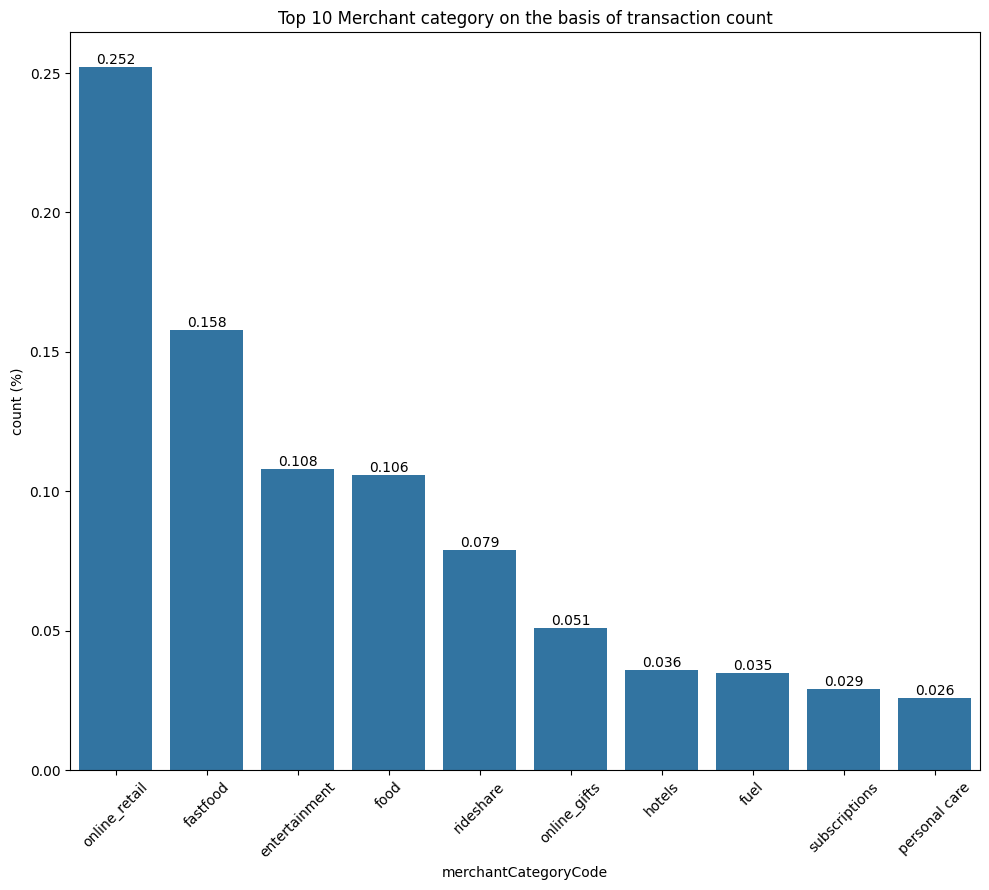

In [52]:
df_transactioncount_per_merchantcategory = round(transaction_df.merchantCategoryCode.value_counts()/total,3).reset_index().head(10)
plt.figure(figsize=(10,9))
ax = sns.barplot(data=df_transactioncount_per_merchantcategory,x="merchantCategoryCode",y="count",order=df_transactioncount_per_merchantcategory["merchantCategoryCode"])
for i in ax.containers:
    ax.bar_label(i,)
plt.ylabel("count (%)")
plt.xlabel("merchantCategoryCode")
plt.xticks(rotation=45)
plt.title("Top 10 Merchant category on the basis of transaction count")
save_fig("Top_10_merchant_category_(transaction_count)")
plt.show()

In [53]:
total_amount = transaction_df.transactionAmount.sum()
total_amount

np.float64(86202649.92000002)

In [54]:
df_transactionAmount_per_merchant = round(((transaction_df.groupby('merchantBrand')['transactionAmount'].sum().sort_values(ascending=False)/total_amount)*100),4).reset_index().head(15)

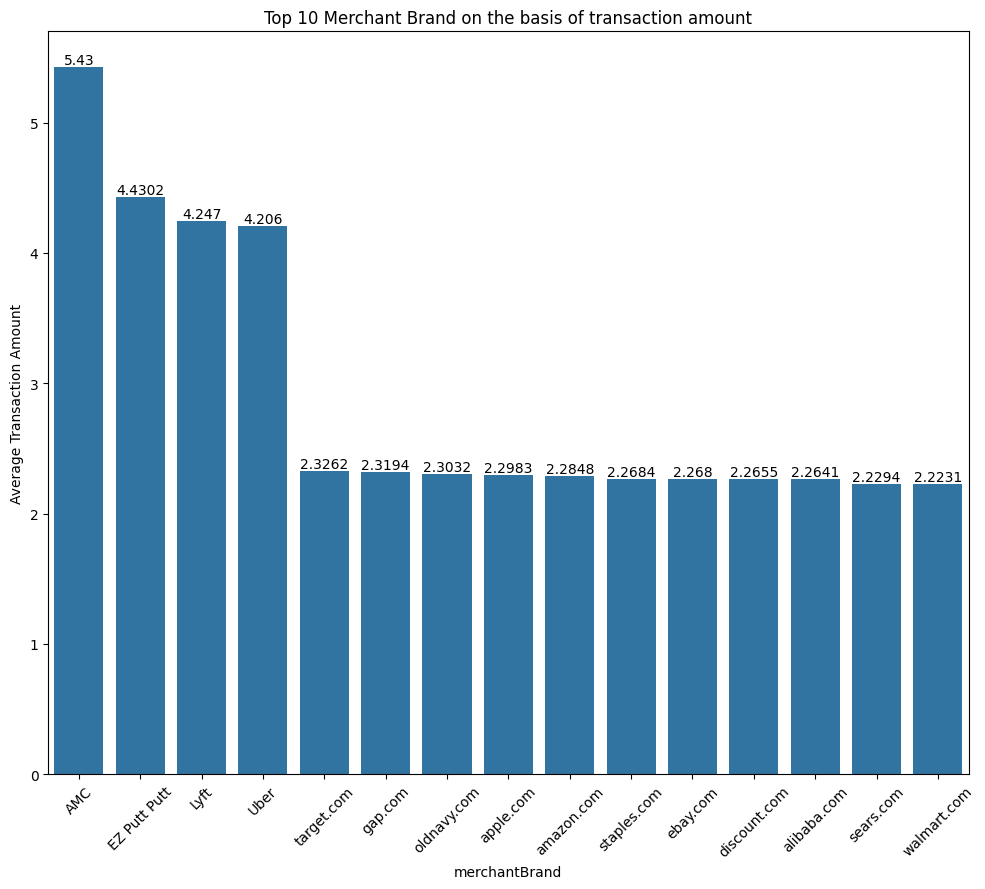

In [55]:
plt.figure(figsize=(10,9))
ax = sns.barplot(data=df_transactionAmount_per_merchant,x="merchantBrand",y="transactionAmount",order=df_transactionAmount_per_merchant["merchantBrand"])
for i in ax.containers:
    ax.bar_label(i,)
plt.ylabel("Average Transaction Amount")
plt.xlabel("merchantBrand")
plt.xticks(rotation=45)
plt.title("Top 10 Merchant Brand on the basis of transaction amount")
save_fig("Top_10_Merchant_brand_(transaction_amount)")
plt.show()

In [56]:
df_transactionAmount_per_merchantcategory=round((transaction_df.groupby('merchantCategoryCode')['transactionAmount'].sum().sort_values(ascending=False)/total_amount)*100,4).reset_index().head(10)

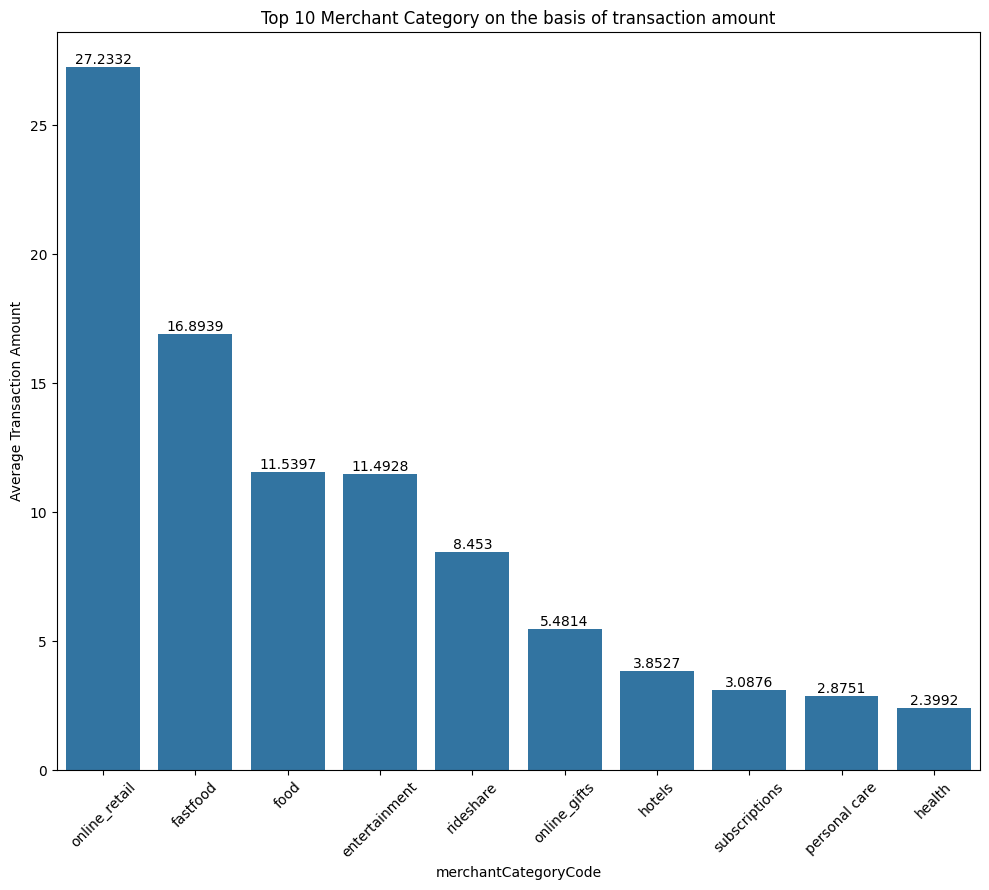

In [57]:
plt.figure(figsize=(10,9))
ax = sns.barplot(data=df_transactionAmount_per_merchantcategory,x="merchantCategoryCode",y="transactionAmount",order=df_transactionAmount_per_merchantcategory["merchantCategoryCode"])
for i in ax.containers:
    ax.bar_label(i,)
plt.ylabel("Average Transaction Amount")
plt.xlabel("merchantCategoryCode")
plt.xticks(rotation=45)
plt.title("Top 10 Merchant Category on the basis of transaction amount")
save_fig("Top_10_Merchant_category_(transaction_amount)")
plt.show()

Outcomes:

* Top four merchant Brands are AMC, EZ Putt Putt, Lyft, Uber on the basis of both transaction count as well as average transaction amount.
* Top Four merchant categories are online_retail, fastfood, entertainment, food on the basis of transaction count whereas the place of fastfood and entertainment gets swapped for average number of transaction.

### Is there a difference in spending behavior between fraudulent and non-fraudulent transactions?

In [58]:
fraud_stats = transaction_df.groupby('isFraud')['transactionAmount'].describe()
print(fraud_stats)

            count        mean         std  min      25%     50%       75%  \
isFraud                                                                     
False    626710.0  133.482184  145.622282  0.0  31.8200   84.42  186.5300   
True      10956.0  232.569388  190.003792  0.0  91.2775  185.36  324.5625   

             max  
isFraud           
False    1825.25  
True     1743.51  


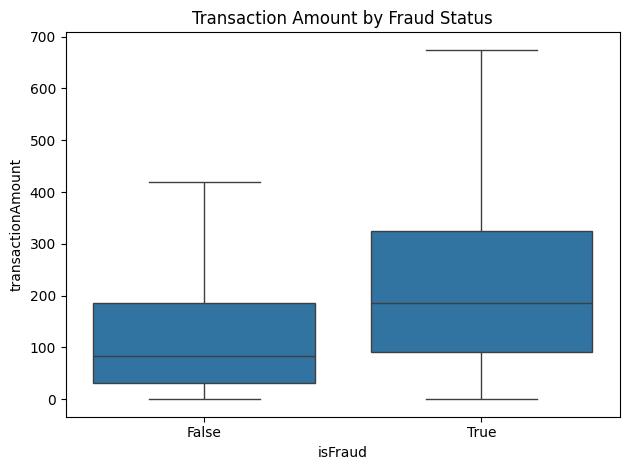

In [59]:
sns.boxplot(data=transaction_df, x='isFraud', y='transactionAmount', showfliers=False)
plt.title("Transaction Amount by Fraud Status")
save_fig("Transaction_Amount_by_Fraud_Status")
plt.show()

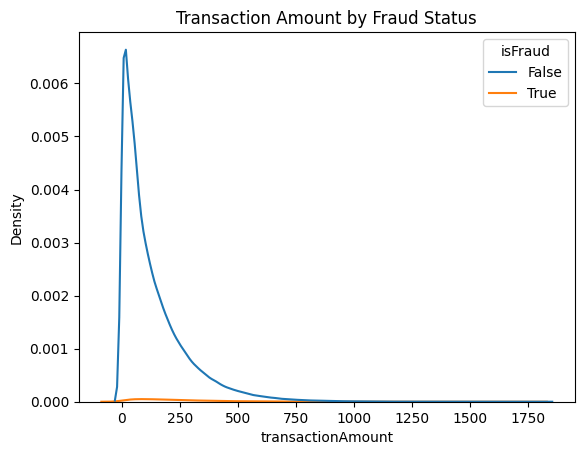

In [60]:
sns.kdeplot(data=transaction_df, x='transactionAmount',hue="isFraud")
plt.title("Transaction Amount by Fraud Status")
plt.show()

* Checking fraud detail: the average transaction amount for fradulant tranactions is quite higher (232.37) than that of non-fradulant transactions (133.48) i.e Fraud targets large transactions

### Which posEntryMode and posConditionCode combinations are more prone to fraud?

In [61]:
total_number_fraud = transaction_df[transaction_df['isFraud'] == 1].shape[0]
total_number_fraud

10956

In [62]:
grouped = transaction_df.groupby(["posEntryMode","posConditionCode"])
fraud_analysis = grouped['isFraud'].agg(
    total_transactions = 'count',
    fraud_transactions ="sum"
).reset_index()

fraud_analysis["fraud_rate"] = fraud_analysis["fraud_transactions"] / fraud_analysis["total_transactions"]
fraud_analysis_sorted = fraud_analysis.sort_values(by="fraud_rate",ascending=False)
fraud_analysis_sorted

,posEntryMode,posConditionCode,total_transactions,fraud_transactions,fraud_rate
14,90.0,99.0,200,21,0.105000
8,9.0,99.0,1799,108,0.060033
2,2.0,99.0,1451,51,0.035148
6,9.0,1.0,154694,4464,0.028857
11,80.0,99.0,125,3,0.024000
7,9.0,8.0,36434,767,0.021052
12,90.0,1.0,12961,268,0.020677
0,2.0,1.0,128560,2534,0.019711
1,2.0,8.0,30342,451,0.014864
10,80.0,8.0,2441,36,0.014748


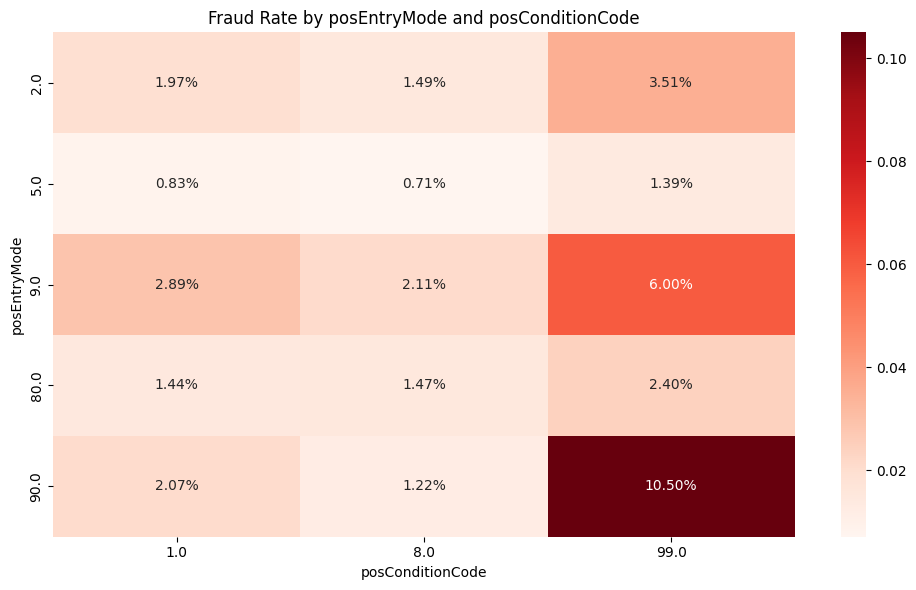

In [63]:
heatmap_data = fraud_analysis.pivot(index='posEntryMode', columns='posConditionCode', values='fraud_rate')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2%", cmap="Reds")
plt.title('Fraud Rate by posEntryMode and posConditionCode')
plt.ylabel('posEntryMode')
plt.xlabel('posConditionCode')
plt.tight_layout()
save_fig("Fraud_Rate_by_posEntryMode_and_posConditionCode")
plt.show()

* Combination of 90.0 posMerchantMode and 99.0 posConditionCode is more prone to fraud.

### Are there specific merchant categories (merchantCategoryCode) that have higher fraud rate?

In [64]:
transaction_df["merchantCategoryCode"].value_counts()

merchantCategoryCode
online_retail           160474
fastfood                100572
entertainment            68655
food                     67840
rideshare                50226
online_gifts             32838
hotels                   22712
fuel                     22397
subscriptions            18258
personal care            16805
mobileapps               14500
health                   14255
online_subscriptions     11149
auto                     10073
airline                   9919
furniture                 7756
food_delivery             4936
gym                       2848
cable/phone               1453
Name: count, dtype: int64

In [65]:
grouped = transaction_df.groupby("merchantCategoryCode")["isFraud"].agg(
    total_transactions = 'count',
    fraud_transactions ="sum"
).reset_index()
grouped["fraud_rate"] = (grouped["fraud_transactions"] / grouped["total_transactions"]) * 100
grouped_sorted = grouped.sort_values(by="fraud_rate",ascending=False)
grouped_sorted = grouped_sorted[~(grouped_sorted["fraud_transactions"] == 0)]
grouped_sorted

,merchantCategoryCode,total_transactions,fraud_transactions,fraud_rate
11,hotels,22712,627,2.760655
14,online_retail,160474,3525,2.196618
17,rideshare,50226,1088,2.166209
1,auto,10073,208,2.064926
5,food,67840,1362,2.007665
0,airline,9919,198,1.996169
13,online_gifts,32838,630,1.918509
10,health,14255,268,1.880042
4,fastfood,100572,1685,1.675417
3,entertainment,68655,903,1.315272


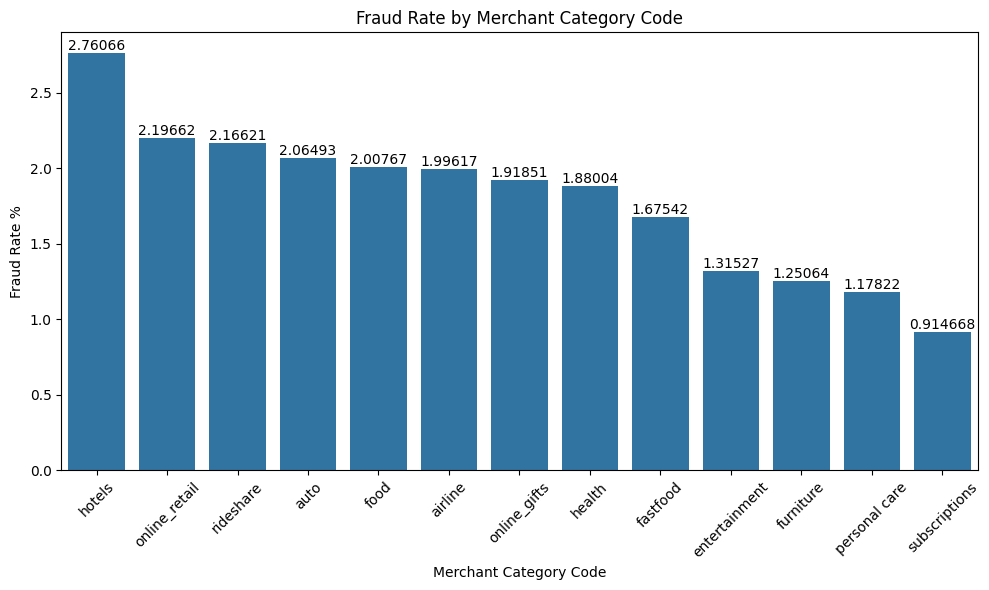

In [66]:
plt.figure(figsize=(10, 6))
ax =sns.barplot(data=grouped_sorted, x='merchantCategoryCode', y='fraud_rate')
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Fraud Rate by Merchant Category Code')
plt.ylabel('Fraud Rate %')
plt.xlabel('Merchant Category Code')
plt.xticks(rotation=45)
plt.tight_layout()
save_fig("Fraud_Rate_by_Merchant_Category_Code")
plt.show()

* Although there is no that much difference of fraud rate between merchant categories. Hotel is the common merchantCategoryCode for fraud transactions followed by online_retail.

### What is the average time gap between accountOpenDate and transactionDateTime for fraudulent transactions?

In [70]:
transaction_df["gap_accOpen_transDateTime"] = (transaction_df["transactionDateTime"] - transaction_df["accountOpenDate"]).dt.days

In [71]:
fraud_df = transaction_df[transaction_df["isFraud"] == 1]
fraud_df = fraud_df.sort_values(["accountNumber", "transactionDateTime"])

In [72]:
first_fraud_per_account = fraud_df.groupby("accountNumber").first().reset_index()
first_fraud_per_account

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,isFraud,currentBalance,cardPresent,expirationDateKeyInMatch,cross_border_count,txn_hour,txn_month,txn_day,merchantBrand,gap_accOpen_transDateTime
0,100547107,100547107,2500,2408.37,2016-04-02 20:23:39,286.07,Tim Hortons #911569,US,US,2.0,...,True,91.63,True,False,0,20,4,2,Tim Hortons,1616
1,101680180,101680180,15000,11035.78,2016-11-02 13:22:04,311.71,walmart.com,US,US,2.0,...,True,3964.22,False,False,0,13,11,2,walmart.com,493
2,102307135,102307135,20000,18682.20,2016-12-16 20:57:58,64.92,Universe Massage #357768,US,US,9.0,...,True,1317.80,True,False,0,20,12,16,Universe Massage,867
3,102635965,102635965,1000,996.90,2016-06-08 10:38:24,209.02,Regal Cinemas #05791,US,US,2.0,...,True,3.10,True,False,0,10,6,8,Regal Cinemas,283
4,103893403,103893403,7500,7174.28,2016-05-03 14:58:34,111.76,Burger King #15452,US,US,2.0,...,True,325.72,True,False,0,14,5,3,Burger King,306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2262,997379599,997379599,5000,1324.59,2016-01-26 19:36:10,679.56,Next Day eCards,US,US,2.0,...,True,3675.41,False,False,0,19,1,26,Next Day eCards,1451
2263,998480579,998480579,5000,5000.00,2016-02-09 00:56:50,140.62,ebay.com,US,US,9.0,...,True,0.00,False,False,0,0,2,9,ebay.com,204
2264,998837644,998837644,5000,1738.26,2016-08-06 10:15:52,314.97,walmart.com,US,US,9.0,...,True,3261.74,False,False,0,10,8,6,walmart.com,677
2265,999275549,999275549,50000,48677.75,2016-06-19 15:59:45,89.14,amazon.com,US,US,9.0,...,True,1322.25,False,False,0,15,6,19,amazon.com,231


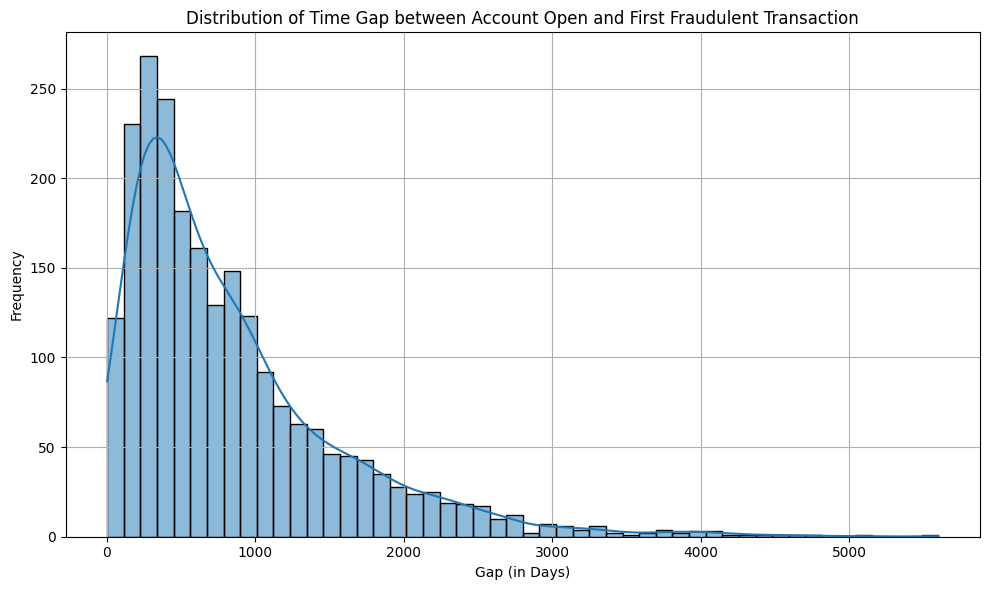

In [73]:
plt.figure(figsize=(10,6))
sns.histplot(first_fraud_per_account["gap_accOpen_transDateTime"], bins=50, kde=True)
plt.title("Distribution of Time Gap between Account Open and First Fraudulent Transaction")
plt.xlabel("Gap (in Days)")
plt.ylabel("Frequency")
plt.grid(True)
save_fig("Distribution_of_Time_Gap_between_Account_Open_and_First_Fraudulent_Transaction")
plt.show()

In [75]:
average_gap= first_fraud_per_account["gap_accOpen_transDateTime"].mean()
print(f"Average Time Gap: {average_gap:.2f} days")
med_gap = first_fraud_per_account["gap_accOpen_transDateTime"].median()
print(f"Median Time Gap: {med_gap:.2f} days")

Average Time Gap: 840.89 days
Median Time Gap: 621.00 days


In [77]:
first_fraud_per_account["gap_accOpen_transDateTime"].describe()

count    2267.000000
mean      840.891045
std       736.353935
min         2.000000
25%       317.000000
50%       621.000000
75%      1123.000000
max      5599.000000
Name: gap_accOpen_transDateTime, dtype: float64

* Average Time Gap: 840.89 days
* Median Time Gap: 621.00 days
* Number of account associated with fraud transaction : 2267
* Min gap, max gap: 2 days, 5599 days

### Do mismatches in cardCVV vs. enteredCVV and currentExpDate vs. expirationDateKeyInMatch correlate with fraud?

In [78]:
transaction_df["expirationDateKeyInMatch"].value_counts()

expirationDateKeyInMatch
False    636703
True        963
Name: count, dtype: int64

In [79]:
transaction_df[["cardCVV","enteredCVV","currentExpDate","expirationDateKeyInMatch"]]

,cardCVV,enteredCVV,currentExpDate,expirationDateKeyInMatch
0,492,492,2020-04-01,False
1,492,492,2023-06-01,False
2,492,492,2027-12-01,False
3,492,492,2029-09-01,False
4,492,492,2024-10-01,False
...,...,...,...,...
637661,127,127,1930-01-01,False
637662,127,127,2026-05-01,False
637663,127,127,2019-10-01,False
637664,127,127,2029-11-01,False


In [80]:
transaction_df["cvv_mismatch"] = transaction_df["cardCVV"] != transaction_df["enteredCVV"]
transaction_df["date_mismatch"] = transaction_df["expirationDateKeyInMatch"] == 0

In [81]:
cvv_table = pd.crosstab(transaction_df["cvv_mismatch"],transaction_df["isFraud"])
cvv_table

isFraud,False,True
cvv_mismatch,,
False,620994,10768
True,5716,188


In [82]:
exp_table = pd.crosstab(transaction_df["date_mismatch"],transaction_df["isFraud"])
exp_table

isFraud,False,True
date_mismatch,,
False,950,13
True,625760,10943


In [83]:
from scipy.stats import chi2_contingency

In [84]:
chi2_cvv, p_cvv, _ ,_= chi2_contingency(cvv_table)
chi2_exp, p_exp, _, _ = chi2_contingency(exp_table)

In [85]:
if p_cvv < 0.05:
    print("There is a significant association between cvv_mismatch and fraud.")
else:
    print("There is no significant association between cvv_mismatch and fraud.")

if p_exp < 0.05:
    print("There is a significant association between expiration date mismatch and fraud.")
else:
    print("There is no significant association between expiration date mismatch and fraud.")

There is a significant association between cvv_mismatch and fraud.
There is no significant association between expiration date mismatch and fraud.


* There is a significant association between cvv_mismatch and fraud.
* There is no significant association between expiration date mismatch and fraud.

### Is there a correlation between creditLimit, availableMoney, and currentBalance?

In [86]:
columns = ["creditLimit","availableMoney","currentBalance"]
subset_df = transaction_df[columns]

correlation_matrix = subset_df.corr()
correlation_matrix

,creditLimit,availableMoney,currentBalance
creditLimit,1.000000,0.856377,0.598408
availableMoney,0.856377,1.000000,0.098767
currentBalance,0.598408,0.098767,1.000000


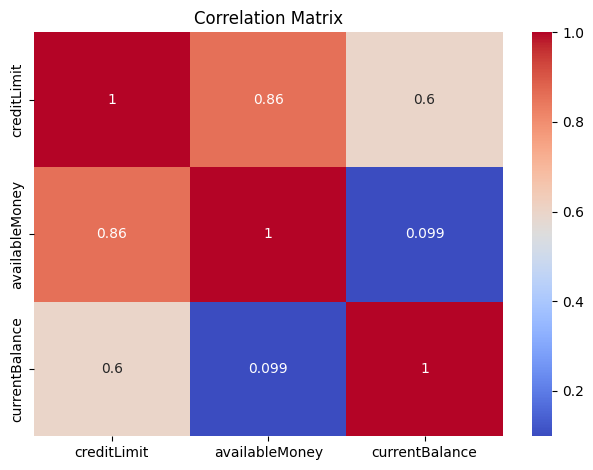

In [87]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.tight_layout()
save_fig("Correlation_Matrix(creditLimit_availableMoney_currentBalance)")
plt.show()

In [88]:
transaction_df[["transactionAmount","availableMoney"]].corr()

,transactionAmount,availableMoney
transactionAmount,1.0000,-0.0116
availableMoney,-0.0116,1.0000


* Positive correlation between creditLimit and availableMoney , it means accounts with high limits also tends to have more available money.
* Same for creditLimit and currentBalance
* But there is negligible correlation between available money and current Balance and same for transation amount and available money.

### Do fraudulent transactions tend to have a certain transactionType or cardPresent flag?

In [89]:
grouped_txn_type = transaction_df.groupby(["transactionType"])["isFraud"].agg(
    total_transactions = "count",
    fraud_transaction = "sum"
).reset_index()
grouped_txn_type["fraud_rate"] = (grouped_txn_type["fraud_transaction"] / grouped_txn_type["total_transactions"])* 100
grouped_txn_type

,transactionType,total_transactions,fraud_transaction,fraud_rate
0,ADDRESS_VERIFICATION,16374,87,0.531330
1,PURCHASE,605224,10581,1.748278
2,REVERSAL,16068,288,1.792382


In [90]:
grouped_cardPresent_type = transaction_df.groupby(["cardPresent"])["isFraud"].agg(
    total_transactions = "count",
    fraud_transaction = "sum"
).reset_index()
grouped_cardPresent_type["fraud_rate"] = (grouped_cardPresent_type["fraud_transaction"] / grouped_cardPresent_type["total_transactions"])* 100
grouped_cardPresent_type

,cardPresent,total_transactions,fraud_transaction,fraud_rate
0,False,338178,6406,1.894269
1,True,299488,4550,1.519260


* There is no sigificant flab based on transaction type for fraud transactions, but address_verification has lowest rate of fraud.
* Presence of card is less prone to fraud compare to no card.

### Are there repeated frauds from the same customerId or accountNumber? What are their patterns?

In [105]:
grouped_accountNumber = transaction_df.groupby(["accountNumber"])["isFraud"].agg(
    total_transactions = "count",
    fraud_transaction = "sum"
).reset_index()
grouped_accountNumber["fraud_rate"] = round((grouped_accountNumber["fraud_transaction"] / grouped_accountNumber["total_transactions"])* 100,4)
grouped_accountNumber.sort_values(by=["total_transactions","fraud_transaction"],ascending=False).head(10)


,accountNumber,total_transactions,fraud_transaction,fraud_rate
1205,318001076,9977,279,2.7964
1978,456044564,8339,94,1.1272
3945,812328116,5461,42,0.7691
4101,838085703,5099,57,1.1179
766,239875038,4671,64,1.3702
4325,877017103,4408,78,1.7695
994,278064853,4201,73,1.7377
1406,353215513,3729,203,5.4438
1185,314506271,3382,44,1.3010
4555,917216469,3237,38,1.1739


###  Do certain customers have repeated fraud history?


In [102]:
fraud_per_customer = transaction_df[transaction_df["isFraud"] == 1]["customerId"].value_counts().head(5).reset_index()

In [ ]:
ax = sns.barplot(data=fraud_per_customer, x="customerId", y="count", order=fraud_per_customer["customerId"])
for i in ax.containers:
    ax.bar_label(i,)
plt.title("Top 5 Customers with Most Fraudulent Transactions")
plt.ylabel("Fraud Count")
plt.xlabel("Customer ID")
plt.xticks(rotation=45)
save_fig("Top_5_Customers_with_Most_Fraudulent_Transactions")
plt.show()

## Is there a pattern between low availableMoney and fraud?


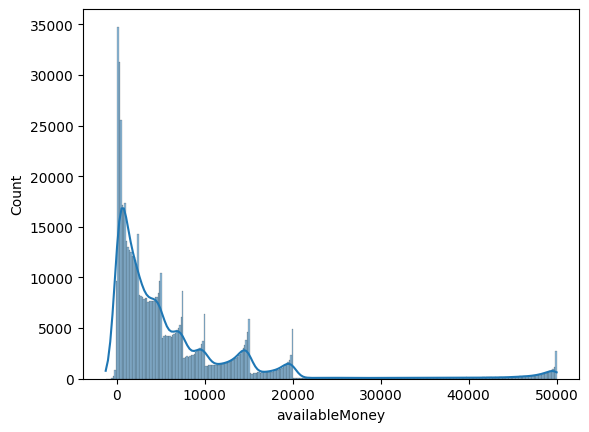

In [106]:
sns.histplot(transaction_df["availableMoney"], kde=True)
plt.show()

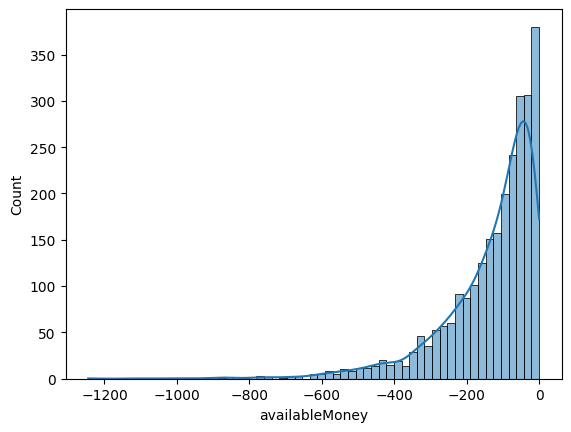

In [110]:
sns.histplot(transaction_df[transaction_df["availableMoney"] < 0]["availableMoney"], kde=True)
plt.show()

In [113]:
fraud_availableMoney = transaction_df[transaction_df["isFraud"] == 1]["availableMoney"]
fraud_availableMoney

0          5000.00
3          4676.52
72         2730.06
79         2394.36
84          910.91
            ...   
637380     5802.15
637545    34545.80
637565    33255.25
637623     6448.10
637627     5756.53
Name: availableMoney, Length: 10956, dtype: float64

In [114]:
non_fraud_availableMoney = transaction_df[transaction_df["isFraud"] == 0]["availableMoney"]
non_fraud_availableMoney

1         4888.67
2         4863.92
4         4449.18
5         4449.18
6         4439.38
           ...   
637661    2574.02
637662    2568.65
637663    2344.95
637664    2206.53
637665    2190.22
Name: availableMoney, Length: 626710, dtype: float64

In [115]:
transaction_df[(transaction_df["isFraud"] == 1) & (transaction_df["availableMoney"] < 0)]

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,cardPresent,expirationDateKeyInMatch,cross_border_count,txn_hour,txn_month,txn_day,merchantBrand,gap_accOpen_transDateTime,cvv_mismatch,date_mismatch
5581,398189423,398189423,250,-56.34,2016-04-27 16:46:39,103.43,Boston Cafe #465229,US,US,2.0,...,True,False,0,16,4,27,Boston Cafe,1414,False,True
13718,824423647,824423647,2500,-70.52,2016-09-19 06:24:50,192.37,AMC #724446,US,US,9.0,...,True,False,0,6,9,19,AMC,759,False,True
24310,772212779,772212779,250,-17.31,2016-08-20 01:26:35,229.99,Boston Cafe #592935,US,US,2.0,...,True,False,0,1,8,20,Boston Cafe,238,False,True
24525,772212779,772212779,250,-131.93,2016-09-18 01:03:35,268.33,John's Bistro,US,US,9.0,...,True,False,0,1,9,18,John's Bistro,267,False,True
52484,235582160,235582160,250,-894.64,2016-07-28 13:34:59,127.75,Uber,US,US,9.0,...,False,False,0,13,7,28,Uber,834,False,True
63395,545561356,545561356,2500,-62.33,2016-07-24 21:06:47,320.18,CVS #618160,US,US,9.0,...,False,False,0,21,7,24,CVS,843,False,True
101630,685565993,685565993,250,-269.83,2016-12-22 16:29:05,125.87,EZ Putt Putt #755869,US,US,9.0,...,True,False,0,16,12,22,EZ Putt Putt,1077,False,True
106699,513829169,513829169,250,-95.92,2016-12-30 11:25:45,231.71,1st BBQ,US,US,9.0,...,True,False,0,11,12,30,1st BBQ,2859,False,True
124334,314112573,314112573,250,-44.15,2016-09-27 19:16:09,549.27,AMC #724446,US,US,9.0,...,False,False,0,19,9,27,AMC,681,False,True
179257,341256661,341256661,250,-125.51,2016-02-14 22:08:16,28.36,Best Bistro #262998,US,US,5.0,...,True,False,0,22,2,14,Best Bistro,720,False,True


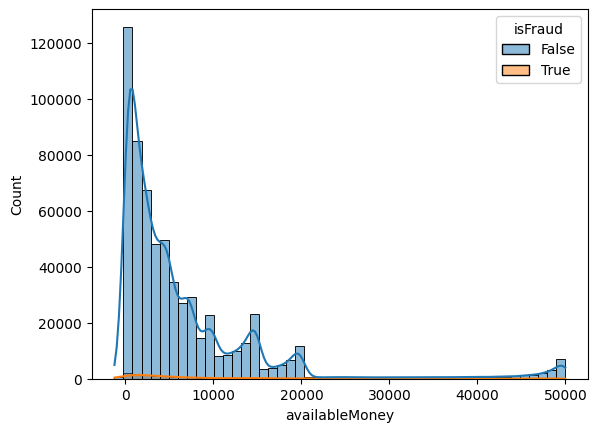

In [121]:
sns.histplot(data = transaction_df,x = "availableMoney", kde=True, hue=transaction_df["isFraud"], bins=50)
plt.show()

In [122]:
transaction_df["availableMoney"].describe()


count    637666.000000
mean       6652.259023
std        9227.524734
min       -1244.930000
25%        1115.270000
50%        3577.325000
75%        8163.632500
max       50000.000000
Name: availableMoney, dtype: float64

In [124]:
bins =[-2000,0,10000,20000,30000,40000,50000]
labels = ["Negative","Very Low","Low","Medium","High","Very High"]
transaction_df["availableMoney_category"] = pd.cut(transaction_df["availableMoney"], bins=bins, labels=labels)

fraud_rate_per_bin = transaction_df.groupby('availableMoney_category')["isFraud"].mean().sort_index()
fraud_rate_per_bin


/tmp/ipykernel_78109/1784165467.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate_per_bin = transaction_df.groupby('availableMoney_category')["isFraud"].mean().sort_index()


availableMoney_category
Negative     0.013117
Very Low     0.017144
Low          0.017858
Medium       0.021264
High         0.019185
Very High    0.013600
Name: isFraud, dtype: float64

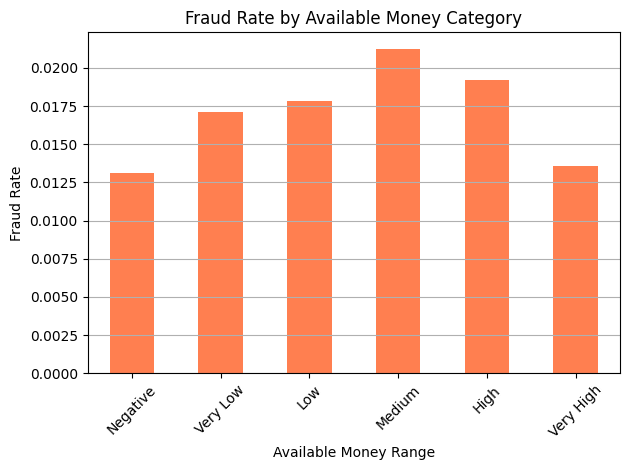

In [127]:
fraud_rate_per_bin.plot(kind="bar", color="coral")
plt.title("Fraud Rate by Available Money Category")
plt.ylabel("Fraud Rate")
plt.xlabel("Available Money Range")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
save_fig("Fraud_Rate_by_Available_Money_Category")
plt.show()

In [128]:
pos_availableMoney = transaction_df[transaction_df["availableMoney"] >= 0]
neg_availableMoney = transaction_df[transaction_df["availableMoney"] < 0]

In [130]:
pos_availableMoney.groupby("isFraud")["availableMoney"].count()

isFraud
False    624152
True      10922
Name: availableMoney, dtype: int64

In [131]:
neg_availableMoney.groupby("isFraud")["availableMoney"].count()

isFraud
False    2558
True       34
Name: availableMoney, dtype: int64

* Medium amount (20000 to 30000) of availableMoney has higher fraud rate (i.e 0.212)
* Only 34 fraud transactions are done by user having negative available money.

## Are customers with high credit limits more/less likely to face fraud?


In [133]:
transaction_df["creditLimit"].value_counts()

creditLimit
5000     126186
7500     104719
15000     91282
10000     67017
20000     63864
2500      59053
50000     37796
500       32490
1000      27661
250       27598
Name: count, dtype: int64

In [134]:
transaction_df[transaction_df["isFraud"] == 1]["creditLimit"].value_counts()

creditLimit
5000     2158
7500     2067
15000    1563
20000    1183
10000    1159
2500      903
50000     643
500       457
1000      424
250       399
Name: count, dtype: int64

In [135]:
grouped = transaction_df.groupby(["creditLimit"])["isFraud"].agg(
    total_transactions = "count",
    fraud_transaction = "sum"
).reset_index()
grouped["fraud_rate"] = (grouped["fraud_transaction"] / grouped["total_transactions"])* 100

In [138]:
grouped[["creditLimit","fraud_rate"]]

,creditLimit,fraud_rate
0,250,1.445757
1,500,1.406587
2,1000,1.532844
3,2500,1.529135
4,5000,1.710174
5,7500,1.973854
6,10000,1.729412
7,15000,1.712276
8,20000,1.852374
9,50000,1.701238


In [139]:
# Perform a chi-square test
chi2_creditLimit, p_creditLimit, _, _ = chi2_contingency(pd.crosstab(transaction_df["creditLimit"], transaction_df["isFraud"]))
if p_creditLimit < 0.05:
    print("There is a significant association between creditLimit and fraud.")
else:
    print("There is no significant association between creditLimit and fraud.")

There is a significant association between creditLimit and fraud.


In [41]:
from scipy.stats import mannwhitneyu

# Separate the two groups
fraud_available_money = transaction_df[transaction_df["isFraud"] == 1]["availableMoney"]
nonfraud_available_money = transaction_df[transaction_df["isFraud"] == 0]["availableMoney"]

stat, p_value = mannwhitneyu(fraud_available_money, nonfraud_available_money, alternative='two-sided')

print(f"P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Result: Significant difference between fraud and non-fraud availableMoney distributions (reject H0)")
else:
    print("Result: No significant difference between fraud and non-fraud availableMoney distributions (fail to reject H0)")


P-value: 0.0606495946941368
Result: No significant difference between fraud and non-fraud availableMoney distributions (fail to reject H0)


* Almost all creditlimit classes has same fraud_rate. creditlimit (7500) topped.
* Chi-square test shows: There is a significant association between creditLimit and fraud.
* Mann-Whitney U statistics test shows: No significant difference between fraud and non-fraud availableMoney distributions

* Mann-Whitney U test checks whether there is a difference between two independent groups.
* Non-parametric counterpart to the t-test for independent samples. 
* Is there a difference in the rank sum?

## What's the average balance difference (available vs current) in fraudulent cases?

In [ ]:
fraud_df = transaction_df[transaction_df["isFraud"] == 1]


In [17]:
fraud_pos_df = fraud_df[fraud_df["availableMoney"] >= 0]
fraud_pos_df["balance_difference"] = fraud_pos_df["currentBalance"] - fraud_pos_df["availableMoney"]

# Calculate average balance difference
average_difference = fraud_pos_df["balance_difference"].mean()

print(f"Average balance difference (currentBalance - availableMoney) in fraudulent transactions (only positive availableMoney): {average_difference:.2f}")

Average balance difference (currentBalance - availableMoney) in fraudulent transactions (only positive availableMoney): -2133.82


/tmp/ipykernel_142631/2082427880.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_pos_df["balance_difference"] = fraud_pos_df["currentBalance"] - fraud_pos_df["availableMoney"]


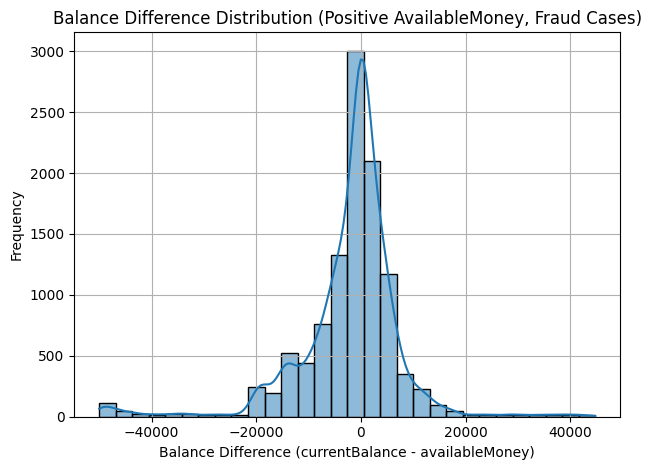

In [18]:
sns.histplot(fraud_pos_df["balance_difference"], bins=30, kde=True)
plt.title("Balance Difference Distribution (Positive AvailableMoney, Fraud Cases)")
plt.xlabel("Balance Difference (currentBalance - availableMoney)")
plt.ylabel("Frequency")
plt.grid(True)
save_fig("Balance_Difference_Distribution_Fraud_Cases_positive(currentBalance - availableMoney)")
plt.show()

In [19]:
fraud_neg_df = fraud_df[fraud_df["availableMoney"] < 0]
fraud_neg_df["balance_difference"] = fraud_neg_df["currentBalance"] - fraud_neg_df["availableMoney"]

# Calculate average balance difference
average_difference = fraud_neg_df["balance_difference"].mean()

print(f"Average balance difference (currentBalance - availableMoney) in fraudulent transactions (only negative availableMoney): {average_difference:.2f}")

Average balance difference (currentBalance - availableMoney) in fraudulent transactions (only negative availableMoney): 797.83


/tmp/ipykernel_142631/1658170179.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_neg_df["balance_difference"] = fraud_neg_df["currentBalance"] - fraud_neg_df["availableMoney"]


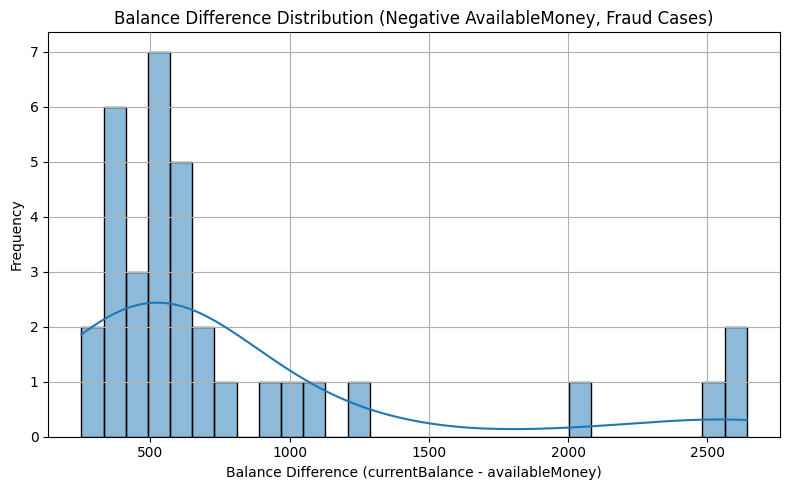

In [20]:
plt.figure(figsize=(8,5))
sns.histplot(fraud_neg_df["balance_difference"], bins=30, kde=True)
plt.title("Balance Difference Distribution (Negative AvailableMoney, Fraud Cases)")
plt.xlabel("Balance Difference (currentBalance - availableMoney)")
plt.ylabel("Frequency")
plt.grid(True)
save_fig("Balance_Difference_Distribution_Fraud_Cases_negative(currentBalance - availableMoney)")
plt.show()

* When available money is negative, the fraud cases mostly involve moderate balance difference.
* When available money is positive, the fraud cases are more variable, many fraud cases involve small balance manipulation.
* There are some extreme outliers, which could represent bigger fraud attemps.

## Does posEntryMode + cardPresent combo indicate more fraud?

In [23]:
transaction_df["cardPresent"].value_counts()

cardPresent
False    338178
True     299488
Name: count, dtype: int64

In [24]:
transaction_df["posEntryMode"].value_counts()

posEntryMode
5.0     255283
9.0     192927
2.0     160353
90.0     16204
80.0     12899
Name: count, dtype: int64

In [27]:
fraud_df.columns

Index(['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionDateTime', 'transactionAmount', 'merchantName',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'isFraud', 'currentBalance', 'cardPresent',
       'expirationDateKeyInMatch', 'cross_border_count', 'txn_hour',
       'txn_month', 'txn_day', 'balance_difference', 'availableMoney_sign'],
      dtype='object')

In [36]:
grouped  = transaction_df.groupby(["posEntryMode","cardPresent"])["isFraud"].agg(
    total_transactions = "count",
    fraud_transaction = "sum"
).reset_index()
grouped["fraud_rate"] = (grouped["fraud_transaction"] / grouped["total_transactions"])
grouped

,posEntryMode,cardPresent,total_transactions,fraud_transaction,fraud_rate
0,2.0,False,85281,1794,0.021036
1,2.0,True,75072,1242,0.016544
2,5.0,False,134844,1051,0.007794
3,5.0,True,120439,1016,0.008436
4,9.0,False,102708,3250,0.031643
5,9.0,True,90219,2089,0.023155
6,80.0,False,6844,118,0.017241
7,80.0,True,6055,70,0.011561
8,90.0,False,8501,193,0.022703
9,90.0,True,7703,133,0.017266


In [37]:
pivoting = grouped.pivot(index='posEntryMode', columns='cardPresent', values='fraud_rate')
pivoting

cardPresent,False,True
posEntryMode,,
2.0,0.021036,0.016544
5.0,0.007794,0.008436
9.0,0.031643,0.023155
80.0,0.017241,0.011561
90.0,0.022703,0.017266


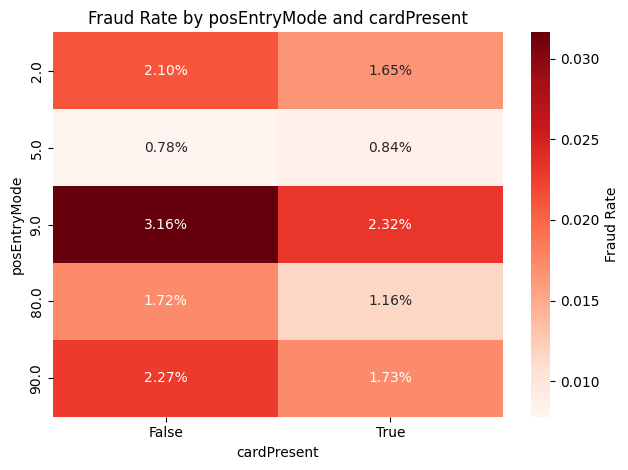

In [40]:
sns.heatmap(pivoting, annot=True,fmt=".2%", cmap="Reds",cbar_kws={'label': 'Fraud Rate'})
plt.title('Fraud Rate by posEntryMode and cardPresent') 
plt.ylabel('posEntryMode')
plt.xlabel('cardPresent')
plt.tight_layout()
save_fig("Fraud_Rate_by_posEntryMode_and_cardPresent")
plt.show()

* The combination of 9.0 posEntryMode and absent of card is more prone to fraud comparatively followed by combination (9, Presence of card)
* Overall posEntryMode encoded as 9.0 is more prone to fraud.

In [6]:
df.columns

Index(['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionDateTime', 'transactionAmount', 'merchantName',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'isFraud', 'currentBalance', 'cardPresent',
       'expirationDateKeyInMatch', 'cross_border_count', 'txn_hour',
       'txn_month', 'txn_day'],
      dtype='object')

## Do certain customers get frauded more on specific merchants?


In [9]:
grouped =  transaction_df.groupby(["customerId","merchantBrand"])["isFraud"].agg(
    total_transactions = "count",
    fraud_transaction = "sum"
).reset_index()
grouped["fraud_rate"] = (grouped["fraud_transaction"] / grouped["total_transactions"])
grouped.sort_values(by=["total_transactions","fraud_transaction"],ascending=False).head(10)

,customerId,merchantBrand,total_transactions,fraud_transaction,fraud_rate
76967,838085703,AMC,1904,30,0.015756
76989,838085703,EZ Putt Putt,1504,15,0.009973
13304,239875038,Rodeway Inn,1106,5,0.004521
12827,235721673,AMC,1006,4,0.003976
11599,226896970,AMC,919,13,0.014146
13289,239875038,Hilton Hotels,831,13,0.015644
12840,235721673,EZ Putt Putt,830,13,0.015663
21904,318001076,gap.com,811,5,0.006165
21907,318001076,sears.com,798,0,0.000000
21909,318001076,target.com,788,108,0.137056


In [20]:
top_10 = grouped.sort_values(by=["fraud_transaction"],ascending=False).head(10)

In [23]:
top_10

,customerId,merchantBrand,total_transactions,fraud_transaction,fraud_rate
21163,311710839,Hyatt House,289,289,1.000000
25874,353215513,34th BBQ,171,171,1.000000
21909,318001076,target.com,788,108,0.137056
75276,822203001,Fast Repair,82,82,1.000000
14758,251625315,KFC,65,65,1.000000
8745,200778999,Regal Cinemas,64,64,1.000000
14757,251625315,In-N-Out,59,59,1.000000
87635,938310147,Lyft,59,59,1.000000
28519,378029122,West End Beauty,58,58,1.000000
63757,717128593,Dinosaur Sandwitch Bar,47,47,1.000000


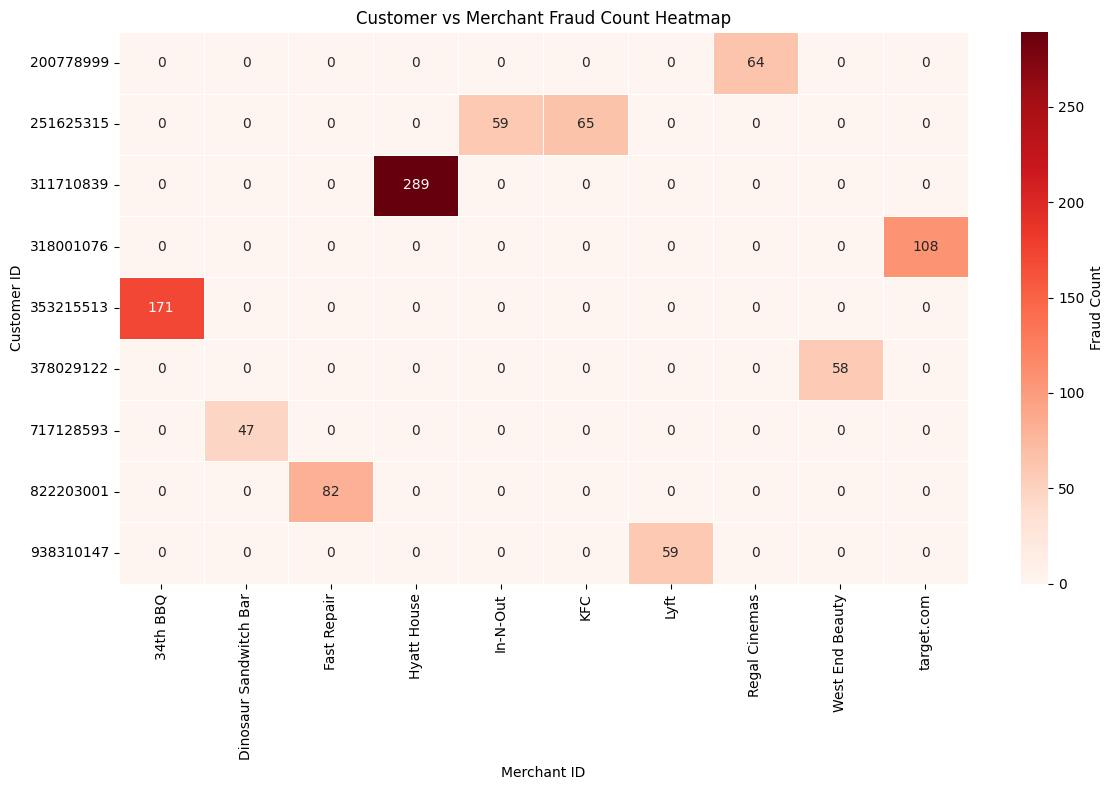

In [27]:
pivot = top_10.pivot(index='customerId', columns='merchantBrand', values='fraud_transaction').fillna(0)

plt.figure(figsize=(12,8))
sns.heatmap(pivot, cmap="Reds", linewidths=0.5, annot=True, fmt=".0f", cbar_kws={'label': 'Fraud Count'})
plt.title('Customer vs Merchant Fraud Count Heatmap')
plt.xlabel('Merchant ID')
plt.ylabel('Customer ID')
save_fig("Customer_vs_Merchant_Fraud_Count_Heatmap")
plt.show()


* 311710839 with Hyatt House merchant has almost all fraud transactions only(289).
* 353215513 with 34th BBQ also has all fraud transctions only (171).

In [26]:
transaction_df[(transaction_df["customerId"] == 311710839) & (transaction_df["merchantBrand"]== "Hyatt House")]

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,transactionType,isFraud,currentBalance,cardPresent,expirationDateKeyInMatch,cross_border_count,txn_hour,txn_month,txn_day,merchantBrand
565628,311710839,311710839,7500,7500.00,2016-01-01 08:02:07,32.69,Hyatt House #524654,US,US,9.0,...,PURCHASE,True,0.00,True,False,0,8,1,1,Hyatt House
565633,311710839,311710839,7500,6776.31,2016-01-01 23:10:49,67.33,Hyatt House #862059,US,US,9.0,...,PURCHASE,True,723.69,False,False,0,23,1,1,Hyatt House
565648,311710839,311710839,7500,5515.17,2016-01-05 02:58:04,136.78,Hyatt House #161001,US,US,2.0,...,PURCHASE,True,1984.83,False,False,0,2,1,5,Hyatt House
565654,311710839,311710839,7500,4584.64,2016-01-06 12:36:42,43.93,Hyatt House #461673,US,US,9.0,...,PURCHASE,True,2915.36,True,False,0,12,1,6,Hyatt House
565668,311710839,311710839,7500,2731.28,2016-01-08 07:47:32,7.01,Hyatt House #551924,US,US,5.0,...,PURCHASE,True,4768.72,True,False,0,7,1,8,Hyatt House
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567422,311710839,311710839,7500,5903.91,2016-12-24 22:31:00,31.21,Hyatt House #469765,US,US,9.0,...,PURCHASE,True,1596.09,False,False,0,22,12,24,Hyatt House
567430,311710839,311710839,7500,5506.61,2016-12-27 07:50:20,59.22,Hyatt House #524654,US,US,2.0,...,PURCHASE,True,1993.39,True,False,0,7,12,27,Hyatt House
567431,311710839,311710839,7500,5447.39,2016-12-27 18:12:17,157.88,Hyatt House #998451,US,US,90.0,...,PURCHASE,True,2052.61,True,False,0,18,12,27,Hyatt House
567435,311710839,311710839,7500,4909.97,2016-12-28 15:40:17,311.50,Hyatt House #972825,US,US,5.0,...,PURCHASE,True,2590.03,True,False,0,15,12,28,Hyatt House


##  Is there a pattern between customer balance and transaction type in fraud cases?

In [30]:
fraud_df = transaction_df[transaction_df["isFraud"] == 1]

In [31]:
fraud_df.groupby(["transactionType"])["currentBalance"].describe()

,count,mean,std,min,25%,50%,75%,max
transactionType,,,,,,,,
ADDRESS_VERIFICATION,87.0,3853.208966,3640.026933,0.0,1134.030,3124.710,5718.5000,16851.82
PURCHASE,10581.0,4410.072962,6214.727730,0.0,687.170,2512.440,5607.7900,47383.32
REVERSAL,288.0,4986.740868,6686.269245,0.0,955.965,3189.285,6549.1025,46229.26


In [33]:
fraud_df["currentBalance"].describe()

count    10956.000000
mean      4420.809836
std       6211.848815
min          0.000000
25%        697.097500
50%       2534.000000
75%       5645.220000
max      47383.320000
Name: currentBalance, dtype: float64

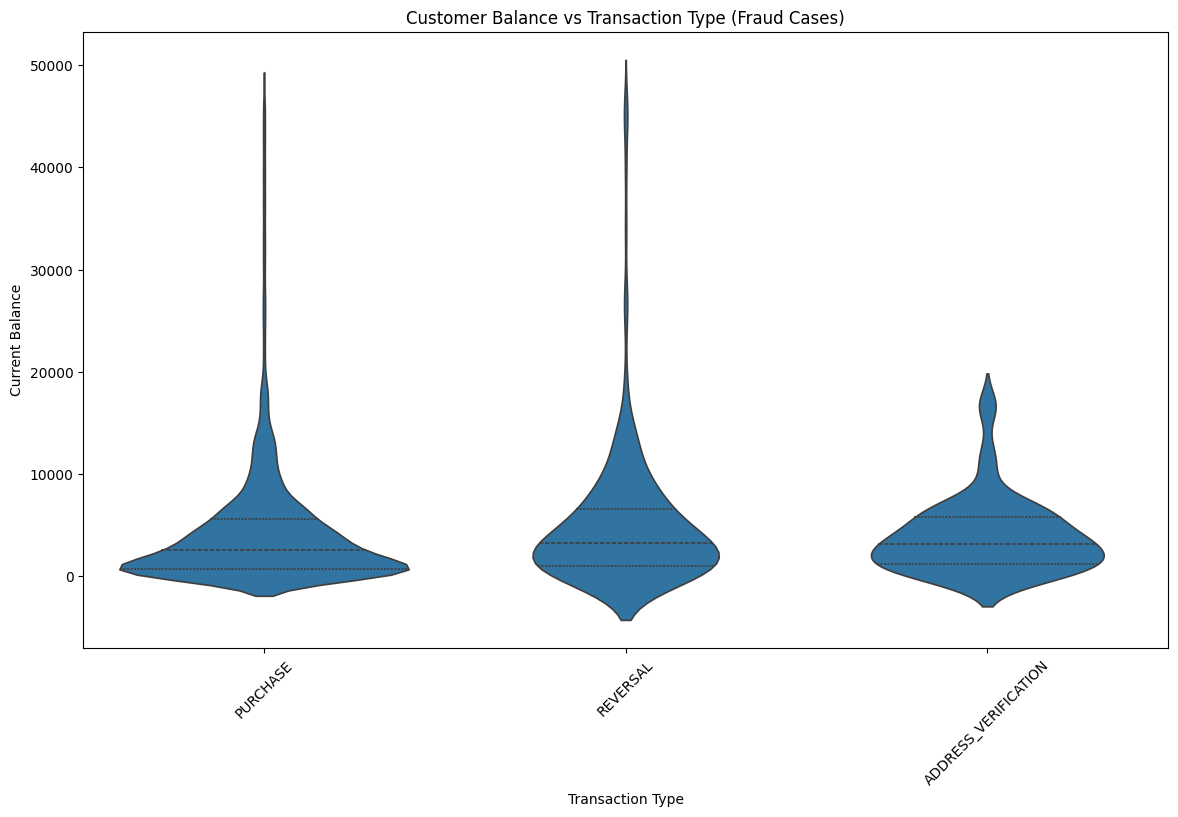

In [34]:
plt.figure(figsize=(14, 8))
sns.violinplot(x='transactionType', y='currentBalance', data=fraud_df, inner='quartile')
plt.title('Customer Balance vs Transaction Type (Fraud Cases)')
plt.xticks(rotation=45)
plt.xlabel('Transaction Type')
plt.ylabel('Current Balance')
plt.show()


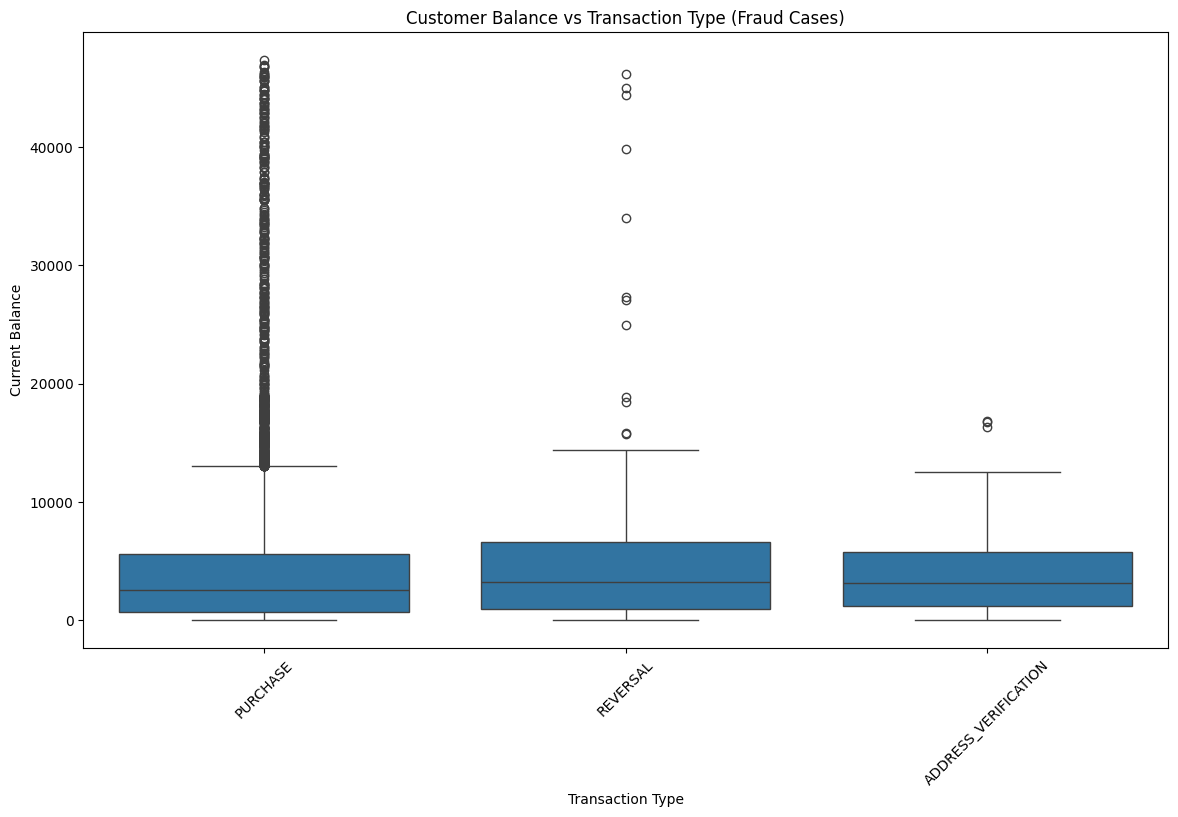

In [35]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='transactionType', y='currentBalance', data=fraud_df)
plt.title('Customer Balance vs Transaction Type (Fraud Cases)')
plt.xticks(rotation=45)
plt.xlabel('Transaction Type')
plt.ylabel('Current Balance')
plt.show()


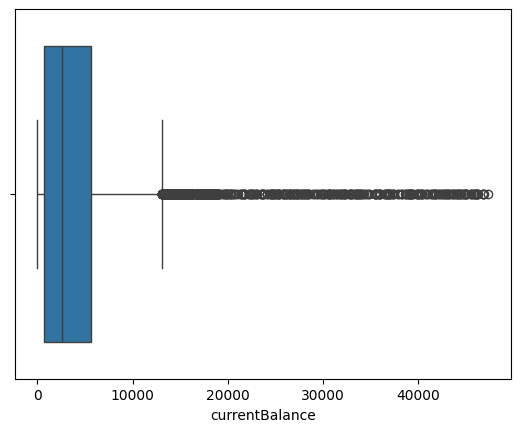

In [37]:
sns.boxplot(data=fraud_df, x="currentBalance")
plt.show()

<Axes: xlabel='currentBalance', ylabel='Count'>

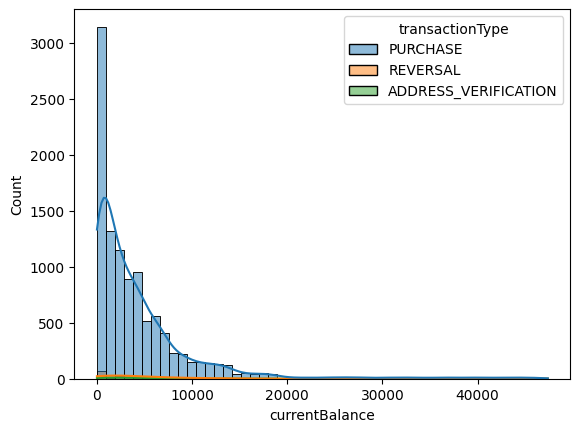

In [42]:
sns.histplot(data=fraud_df, x='currentBalance',hue="transactionType",bins=50, kde=True)

<Axes: xlabel='currentBalance', ylabel='transactionAmount'>

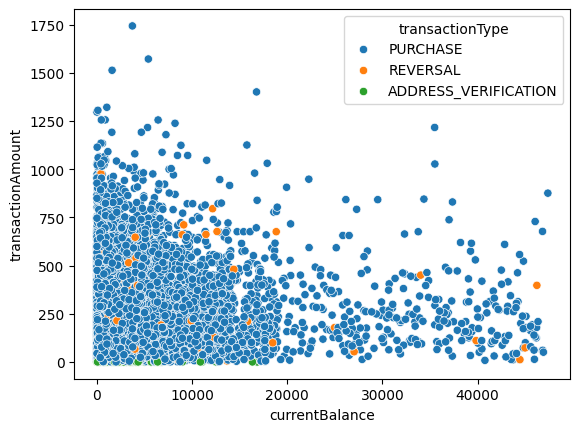

In [43]:
sns.scatterplot(data=fraud_df, x='currentBalance', y='transactionAmount', hue='transactionType')

In [44]:
transaction_df.columns

Index(['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionDateTime', 'transactionAmount', 'merchantName',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'isFraud', 'currentBalance', 'cardPresent',
       'expirationDateKeyInMatch', 'cross_border_count', 'txn_hour',
       'txn_month', 'txn_day', 'merchantBrand'],
      dtype='object')

## How date of last address change associate with fraud transactions?

In [53]:
transaction_df["dateOfLastAddressChange"] = pd.to_datetime(transaction_df["dateOfLastAddressChange"], dayfirst=True)

In [54]:
transaction_df["dateOfLastAddressChange"].iloc[:]

0        2014-08-03
1        2014-08-03
2        2014-08-03
3        2014-08-03
4        2014-08-03
            ...    
637661   2016-06-03
637662   2016-06-03
637663   2016-06-03
637664   2016-06-03
637665   2016-06-03
Name: dateOfLastAddressChange, Length: 637666, dtype: datetime64[ns]

In [ ]:
transaction_df["gap_addressChange_transaction"] = (transaction_df["transactionDateTime"] - transaction_df["dateOfLastAddressChange"]).dt.days

# recentAddressChange' if gap < 30 days
transaction_df["recentAddressChange"] = transaction_df["gap_addressChange_transaction"] < 30

In [57]:
transaction_df.groupby("isFraud")["gap_addressChange_transaction"].describe()

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
False,626710.0,535.060687,678.716635,0.0,59.0,266.0,783.0,11320.0
True,10956.0,485.095199,647.063353,0.0,51.0,204.0,674.0,5785.0


In [60]:
transaction_df["recentAddressChange"].value_counts()

recentAddressChange
False    533991
True     103675
Name: count, dtype: int64

In [58]:
transaction_df.groupby("isFraud")["recentAddressChange"].mean()

isFraud
False    0.162324
True     0.177528
Name: recentAddressChange, dtype: float64

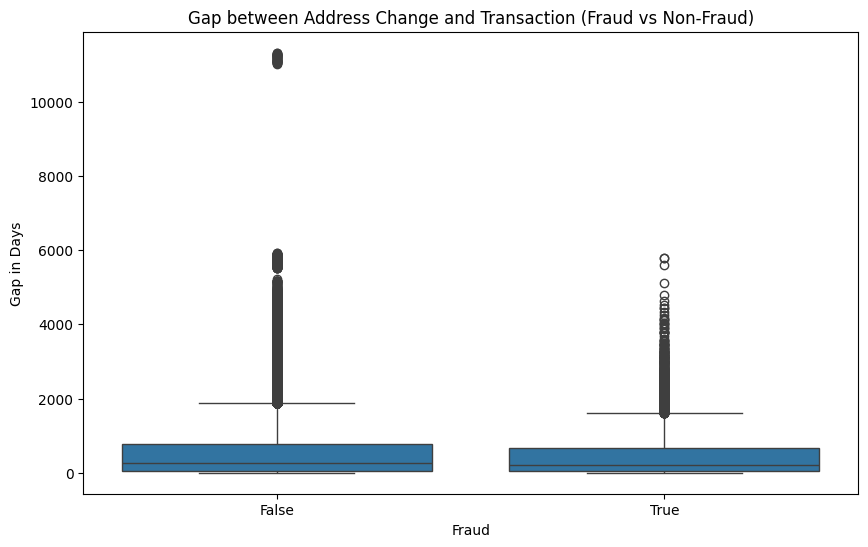

In [62]:
plt.figure(figsize=(10,6))
sns.boxplot(x="isFraud", y="gap_addressChange_transaction", data=transaction_df)
plt.title("Gap between Address Change and Transaction (Fraud vs Non-Fraud)")
plt.xlabel("Fraud")
plt.ylabel("Gap in Days")
plt.show()

* Outliers are present heavily in non-fraud cases (some customers didn’t update their address for many years — we can see extreme points up to ~11,000 days ≈ 30 years).

* Fraud cases have fewer extreme outliers — meaning fraudsters' addresses are more recently changed compared to random genuine users.

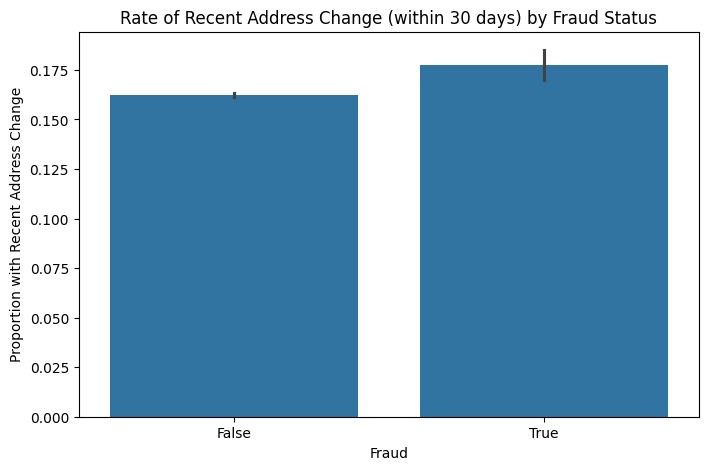

In [66]:
plt.figure(figsize=(8,5))
sns.barplot(x="isFraud", y="recentAddressChange", data=transaction_df)
plt.title("Rate of Recent Address Change (within 30 days) by Fraud Status")
plt.xlabel("Fraud")
plt.ylabel("Proportion with Recent Address Change")
plt.show()


* Fraudulent transactions (True) are more likely to have had a recent address change (within 30 days) compared to non-fraudulent transactions (False).
* The difference is visible, but not massive.

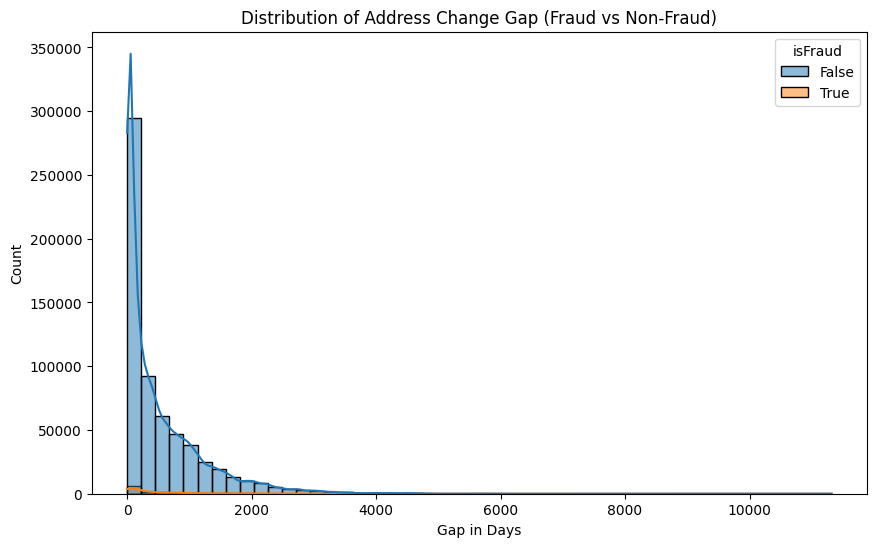

In [65]:
plt.figure(figsize=(10,6))
sns.histplot(data=transaction_df, x="gap_addressChange_transaction", hue="isFraud", bins=50, kde=True)
plt.title("Distribution of Address Change Gap (Fraud vs Non-Fraud)")
plt.xlabel("Gap in Days")
plt.ylabel("Count")
plt.show()